# Stochastic Differential Equation (SDE) Integration Tutorial

This tutorial demonstrates how to use the stochastic differential equation (SDE) integrators in BrainTools. We'll cover:

1. **Basic integrators**: Euler-Maruyama, Milstein, Exponential Euler
2. **Advanced integrators**: Heun, Tamed Euler, Implicit Euler
3. **Stochastic Runge-Kutta methods**: SRK2, SRK3, SRK4
4. **Itô vs Stratonovich interpretations**
5. **Performance comparison and strong/weak convergence analysis**
6. **Practical neuroscience examples with noise**

All integrators in BrainTools operate on JAX PyTrees, use the global time step from `brainstate.environ`, and draw Gaussian noise using `brainstate.random`.

## Setup and Imports

In [1]:
import brainstate
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import braintools

# Set up plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Enable JAX's float64 for better precision in this tutorial
jax.config.update("jax_enable_x64", True)

# Set random seed for reproducibility
brainstate.random.set_key(jax.random.PRNGKey(42))

## 1. Introduction to Stochastic Differential Equations

A stochastic differential equation (SDE) has the general form:

$$dY_t = f(Y_t, t) dt + g(Y_t, t) dW_t$$

where:
- $f(y, t)$ is the **drift** function
- $g(y, t)$ is the **diffusion** function  
- $dW_t$ is a Wiener process (Brownian motion increment)

Let's start with the **Geometric Brownian Motion** (GBM), a fundamental SDE:

$$dY_t = \mu Y_t dt + \sigma Y_t dW_t$$

The analytical solution is: $Y_t = Y_0 \exp\left((\mu - \frac{\sigma^2}{2})t + \sigma W_t\right)$

In [2]:
# Define Geometric Brownian Motion
def gbm_drift(y, t, mu=0.05, sigma=0.2):
    """Drift function: f(y,t) = mu * y"""
    return mu * y


def gbm_diffusion(y, t, mu=0.05, sigma=0.2):
    """Diffusion function: g(y,t) = sigma * y"""
    return sigma * y


# Parameters
y0 = 1.0
mu = 0.05
sigma = 0.2
t_final = 2.0
dt = 0.01

# Time array
t_array = jnp.arange(0, t_final + dt, dt)
n_steps = len(t_array) - 1

print(f"Integration from t=0 to t={t_final} with dt={dt}")
print(f"Number of steps: {n_steps}")
print(f"Parameters: μ={mu}, σ={sigma}")

Integration from t=0 to t=2.0 with dt=0.01
Number of steps: 200
Parameters: μ=0.05, σ=0.2


### Generic SDE Integration Function

Let's create a helper function for integrating SDEs, similar to what we had for ODEs:

In [3]:
def integrate_sde(integrator_func, df, dg, y0, t_array, *args, **kwargs):
    """Generic SDE integration function"""
    dt = t_array[1] - t_array[0]
    y = y0

    def step_run(y0, t):
        y1 = integrator_func(df, dg, y0, t, *args, **kwargs)
        return y1, y1

    with brainstate.environ.context(dt=dt):
        y, y_values = brainstate.transform.scan(step_run, y, t_array)
    return jax.block_until_ready(y_values)


def analytical_gbm_paths(t_array, y0, mu, sigma, n_paths=1, key=None):
    """Generate analytical GBM paths for comparison"""
    dt = t_array[1] - t_array[0]
    dW = brainstate.random.randn(n_paths, len(t_array)) * jnp.sqrt(dt)
    W = jnp.cumsum(dW, axis=1)
    W = jnp.concatenate([jnp.zeros((n_paths, 1)), W[:, :-1]], axis=1)

    exponent = (mu - 0.5 * sigma ** 2) * t_array[None, :] + sigma * W
    return y0 * jnp.exp(exponent)

## 2. Basic SDE Integrators

### Euler-Maruyama Method

The simplest SDE integrator, with strong order 0.5:

$$Y_{n+1} = Y_n + f(Y_n, t_n) \Delta t + g(Y_n, t_n) \Delta W_n$$

where $\Delta W_n \sim \mathcal{N}(0, \Delta t)$

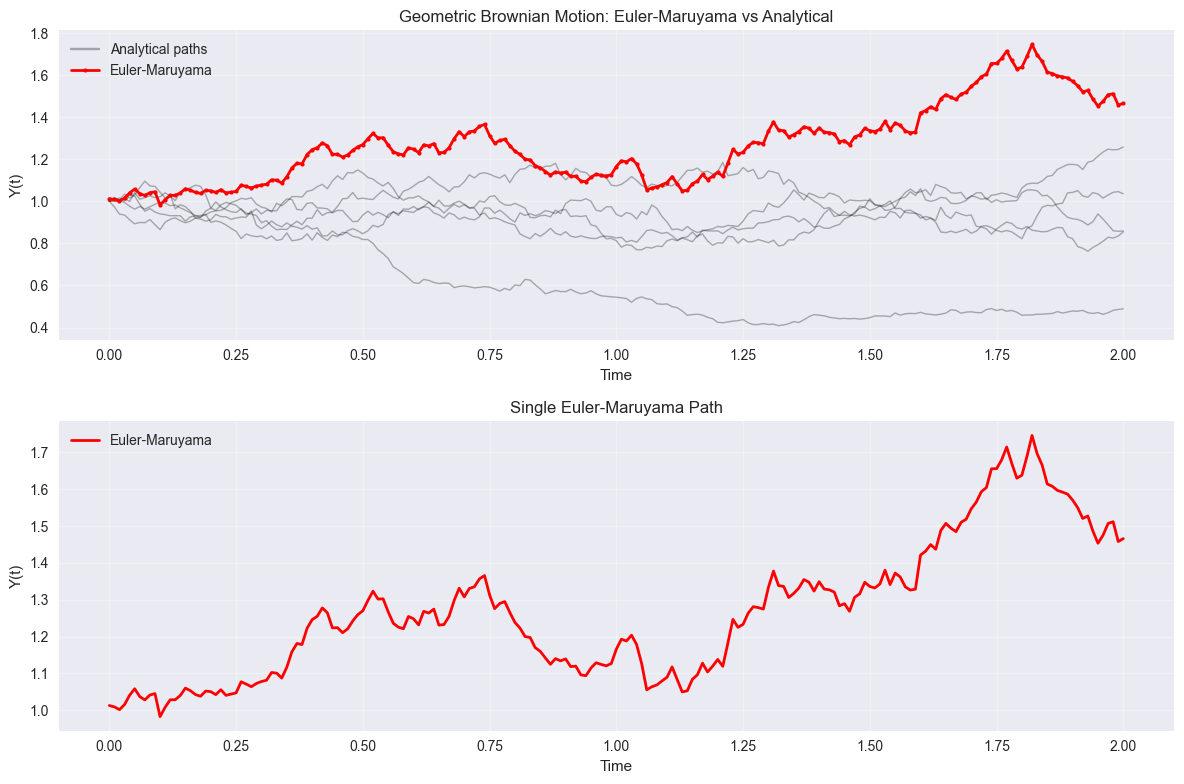

Final value (Euler-Maruyama): 1.4660
Expected final value (mean): 1.1052


In [4]:
# Integrate using Euler-Maruyama method
brainstate.random.set_key(jax.random.PRNGKey(42))  # For reproducibility
y_euler = integrate_sde(braintools.quad.sde_euler_step, gbm_drift, gbm_diffusion,
                        y0, t_array, mu, sigma)

# Generate multiple analytical paths for comparison
n_paths = 5
analytical_paths = analytical_gbm_paths(t_array, y0, mu, sigma, n_paths,
                                        jax.random.PRNGKey(123))

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
# Plot analytical paths in gray
for i in range(n_paths):
    plt.plot(t_array, analytical_paths[i], 'k-', alpha=0.3, linewidth=1)
    if i == 0:
        plt.plot([], [], 'k-', alpha=0.3, label='Analytical paths')

plt.plot(t_array, y_euler, 'ro-', markersize=3, label='Euler-Maruyama', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Y(t)')
plt.title('Geometric Brownian Motion: Euler-Maruyama vs Analytical')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(t_array, y_euler, 'r-', linewidth=2, label='Euler-Maruyama')
plt.xlabel('Time')
plt.ylabel('Y(t)')
plt.title('Single Euler-Maruyama Path')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final value (Euler-Maruyama): {y_euler[-1]:.4f}")
print(f"Expected final value (mean): {y0 * jnp.exp(mu * t_final):.4f}")

### Milstein Method

The Milstein method has strong order 1.0 and includes a correction term:

$$Y_{n+1} = Y_n + f(Y_n, t_n) \Delta t + g(Y_n, t_n) \Delta W_n + \frac{1}{2} g(Y_n, t_n) \frac{\partial g}{\partial y}(Y_n, t_n) [(\Delta W_n)^2 - \Delta t]$$

For Itô SDEs, the last term uses $(\Delta W_n)^2 - \Delta t$. For Stratonovich SDEs, it uses $(\Delta W_n)^2$.

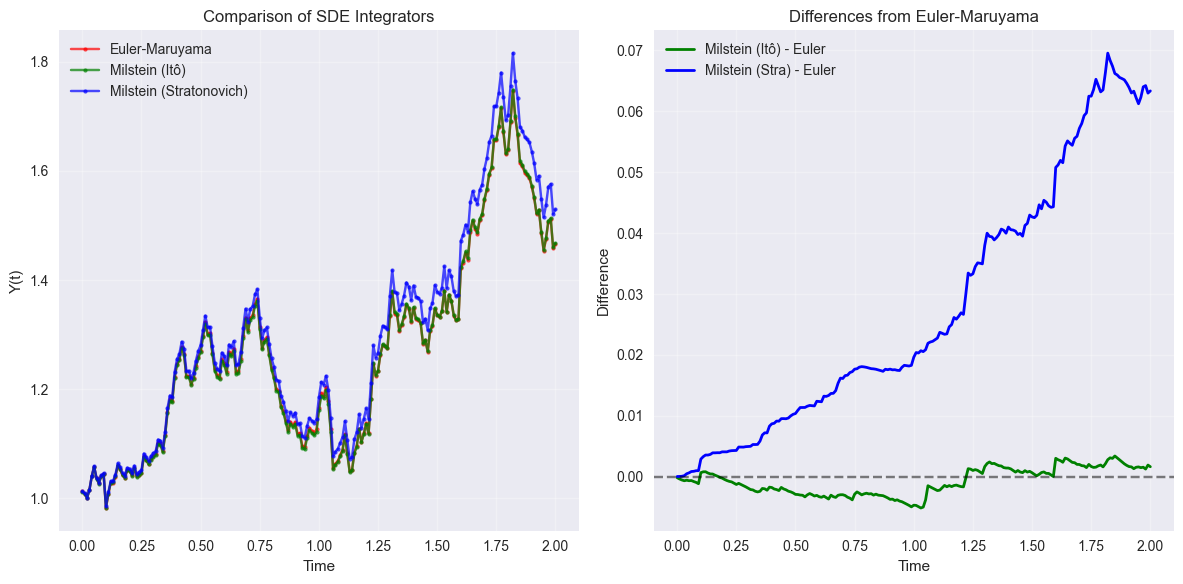

Final values:
Euler-Maruyama:      1.465971
Milstein (Itô):      1.467649
Milstein (Stra):     1.529273


In [5]:
# Compare Euler-Maruyama vs Milstein
brainstate.random.set_key(jax.random.PRNGKey(42))  # Same random seed for fair comparison

y_euler_comp = integrate_sde(braintools.quad.sde_euler_step, gbm_drift, gbm_diffusion,
                             y0, t_array, mu, sigma)

brainstate.random.set_key(jax.random.PRNGKey(42))  # Reset to same seed
y_milstein_ito = integrate_sde(braintools.quad.sde_milstein_step, gbm_drift, gbm_diffusion,
                               y0, t_array, mu, sigma, sde_type='ito')

brainstate.random.set_key(jax.random.PRNGKey(42))  # Reset to same seed  
y_milstein_stra = integrate_sde(braintools.quad.sde_milstein_step, gbm_drift, gbm_diffusion,
                                y0, t_array, mu, sigma, sde_type='stra')

# Plot comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(t_array, y_euler_comp, 'ro-', markersize=3, label='Euler-Maruyama', alpha=0.7)
plt.plot(t_array, y_milstein_ito, 'go-', markersize=3, label='Milstein (Itô)', alpha=0.7)
plt.plot(t_array, y_milstein_stra, 'bo-', markersize=3, label='Milstein (Stratonovich)', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Y(t)')
plt.title('Comparison of SDE Integrators')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot differences
plt.subplot(1, 2, 2)
diff_milstein_ito = y_milstein_ito - y_euler_comp
diff_milstein_stra = y_milstein_stra - y_euler_comp

plt.plot(t_array, diff_milstein_ito, 'g-', linewidth=2, label='Milstein (Itô) - Euler')
plt.plot(t_array, diff_milstein_stra, 'b-', linewidth=2, label='Milstein (Stra) - Euler')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Difference')
plt.title('Differences from Euler-Maruyama')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final values:")
print(f"Euler-Maruyama:      {y_euler_comp[-1]:.6f}")
print(f"Milstein (Itô):      {y_milstein_ito[-1]:.6f}")
print(f"Milstein (Stra):     {y_milstein_stra[-1]:.6f}")

### Exponential Euler Method

The exponential Euler method uses exact integration of the linearized drift term and is particularly useful for stiff SDEs:

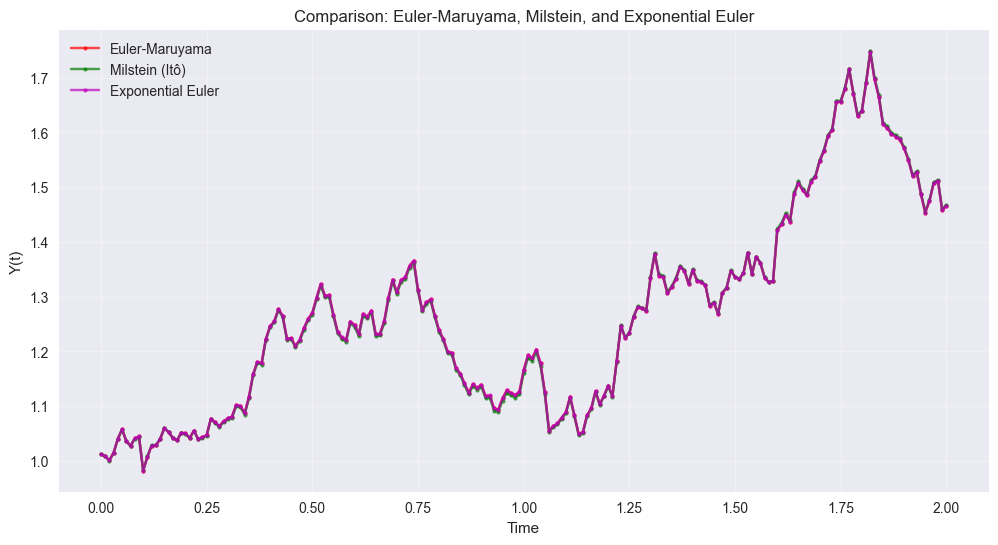

Final values:
Euler-Maruyama:   1.465971
Milstein (Itô):   1.467649
Exponential Euler: 1.466008


In [6]:
# Test Exponential Euler on the GBM (needs first argument for noise shape)
def integrate_sde_expeuler(df, dg, y0, t_array, *args):
    """Special integration for exponential Euler (needs first arg for noise)"""
    dt = t_array[1] - t_array[0]
    y = y0

    def step_run(y0, t):
        # Exponential Euler needs the first argument for noise shape
        y1 = braintools.quad.sde_expeuler_step(df, dg, y0, t, *args)
        return y1, y1

    with brainstate.environ.context(dt=dt):
        y, y_values = brainstate.transform.scan(step_run, y, t_array)
    return jax.block_until_ready(y_values)


brainstate.random.set_key(jax.random.PRNGKey(42))
y_expeuler = integrate_sde_expeuler(gbm_drift, gbm_diffusion, y0, t_array, mu, sigma)

# Compare all methods
plt.figure(figsize=(12, 6))

plt.plot(t_array, y_euler_comp, 'ro-', markersize=3, label='Euler-Maruyama', alpha=0.7)
plt.plot(t_array, y_milstein_ito, 'go-', markersize=3, label='Milstein (Itô)', alpha=0.7)
plt.plot(t_array, y_expeuler, 'mo-', markersize=3, label='Exponential Euler', alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Y(t)')
plt.title('Comparison: Euler-Maruyama, Milstein, and Exponential Euler')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final values:")
print(f"Euler-Maruyama:   {y_euler_comp[-1]:.6f}")
print(f"Milstein (Itô):   {y_milstein_ito[-1]:.6f}")
print(f"Exponential Euler: {y_expeuler[-1]:.6f}")

## 3. Advanced SDE Integrators

### Stochastic Heun Method

The stochastic Heun method is a predictor-corrector scheme:

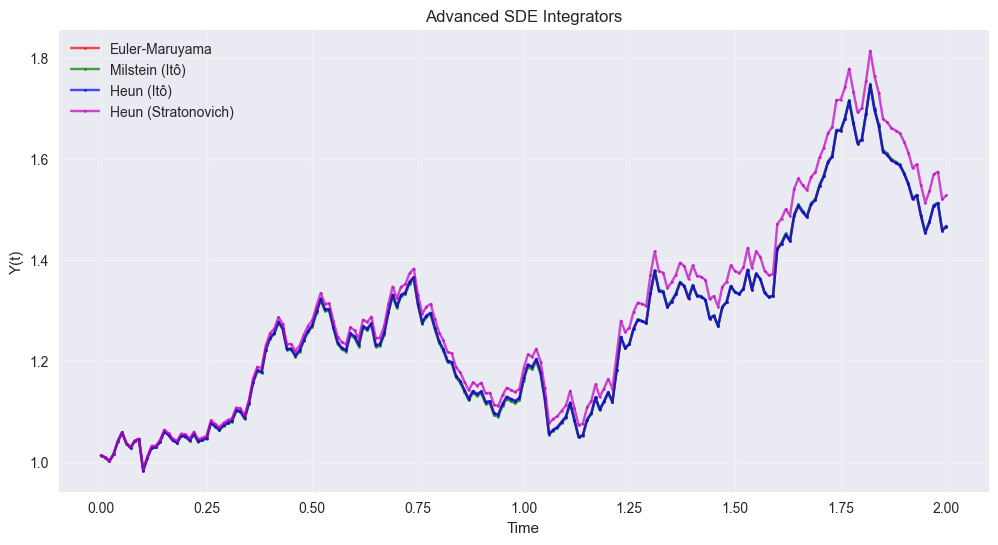

Final values:
Euler-Maruyama:     1.465971
Milstein (Itô):     1.467649
Heun (Itô):         1.466096
Heun (Stratonovich): 1.527920


In [7]:
# Test Stochastic Heun method
brainstate.random.set_key(jax.random.PRNGKey(42))
y_heun_ito = integrate_sde(braintools.quad.sde_heun_step, gbm_drift, gbm_diffusion,
                           y0, t_array, mu, sigma, sde_type='ito')

brainstate.random.set_key(jax.random.PRNGKey(42))
y_heun_stra = integrate_sde(braintools.quad.sde_heun_step, gbm_drift, gbm_diffusion,
                            y0, t_array, mu, sigma, sde_type='stra')

plt.figure(figsize=(12, 6))

plt.plot(t_array, y_euler_comp, 'ro-', markersize=2, label='Euler-Maruyama', alpha=0.7)
plt.plot(t_array, y_milstein_ito, 'go-', markersize=2, label='Milstein (Itô)', alpha=0.7)
plt.plot(t_array, y_heun_ito, 'bo-', markersize=2, label='Heun (Itô)', alpha=0.7)
plt.plot(t_array, y_heun_stra, 'mo-', markersize=2, label='Heun (Stratonovich)', alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Y(t)')
plt.title('Advanced SDE Integrators')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final values:")
print(f"Euler-Maruyama:     {y_euler_comp[-1]:.6f}")
print(f"Milstein (Itô):     {y_milstein_ito[-1]:.6f}")
print(f"Heun (Itô):         {y_heun_ito[-1]:.6f}")
print(f"Heun (Stratonovich): {y_heun_stra[-1]:.6f}")

### Tamed Euler Method

The tamed Euler method prevents explosion for SDEs with superlinear growth in the drift:

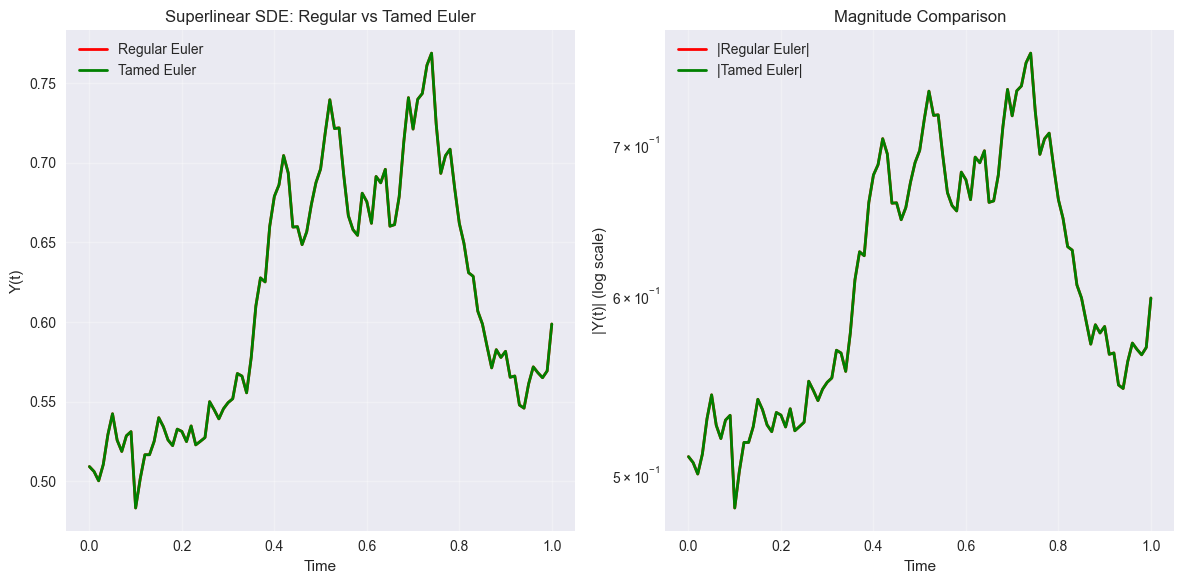

Final values:
Regular Euler: 0.598785
Tamed Euler:   0.598779


In [8]:
# Example with superlinear growth: dY = Y^3 dt + Y dW
def superlinear_drift(y, t, alpha=1.0, sigma=0.5):
    """Superlinear drift: f(y,t) = alpha * y^3"""
    return alpha * y ** 3


def linear_diffusion(y, t, alpha=1.0, sigma=0.5):
    """Linear diffusion: g(y,t) = sigma * y"""
    return sigma * y


# Parameters for superlinear problem
y0_super = 0.5
alpha = 0.1
sigma_super = 0.3
t_final_super = 1.0
dt_super = 0.01
t_array_super = jnp.arange(0, t_final_super + dt_super, dt_super)

# Compare regular Euler vs Tamed Euler
try:
    brainstate.random.set_key(jax.random.PRNGKey(42))
    y_euler_super = integrate_sde(braintools.quad.sde_euler_step, superlinear_drift, linear_diffusion,
                                  y0_super, t_array_super, alpha, sigma_super)
    euler_success = True
except:
    print("Regular Euler failed (likely explosion)")
    euler_success = False

brainstate.random.set_key(jax.random.PRNGKey(42))
y_tamed = integrate_sde(braintools.quad.sde_tamed_euler_step, superlinear_drift, linear_diffusion,
                        y0_super, t_array_super, alpha, sigma_super)

plt.figure(figsize=(12, 6))

if euler_success:
    plt.subplot(1, 2, 1)
    plt.plot(t_array_super, y_euler_super, 'r-', linewidth=2, label='Regular Euler')
    plt.plot(t_array_super, y_tamed, 'g-', linewidth=2, label='Tamed Euler')
    plt.xlabel('Time')
    plt.ylabel('Y(t)')
    plt.title('Superlinear SDE: Regular vs Tamed Euler')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.semilogy(t_array_super, jnp.abs(y_euler_super), 'r-', linewidth=2, label='|Regular Euler|')
    plt.semilogy(t_array_super, jnp.abs(y_tamed), 'g-', linewidth=2, label='|Tamed Euler|')
    plt.xlabel('Time')
    plt.ylabel('|Y(t)| (log scale)')
    plt.title('Magnitude Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.plot(t_array_super, y_tamed, 'g-', linewidth=2, label='Tamed Euler')
    plt.xlabel('Time')
    plt.ylabel('Y(t)')
    plt.title('Superlinear SDE: Tamed Euler (Regular Euler Failed)')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if euler_success:
    print(f"Final values:")
    print(f"Regular Euler: {y_euler_super[-1]:.6f}")
    print(f"Tamed Euler:   {y_tamed[-1]:.6f}")
else:
    print(f"Tamed Euler final value: {y_tamed[-1]:.6f}")

### Implicit Euler Method

The implicit Euler method uses fixed-point iterations for better stability:

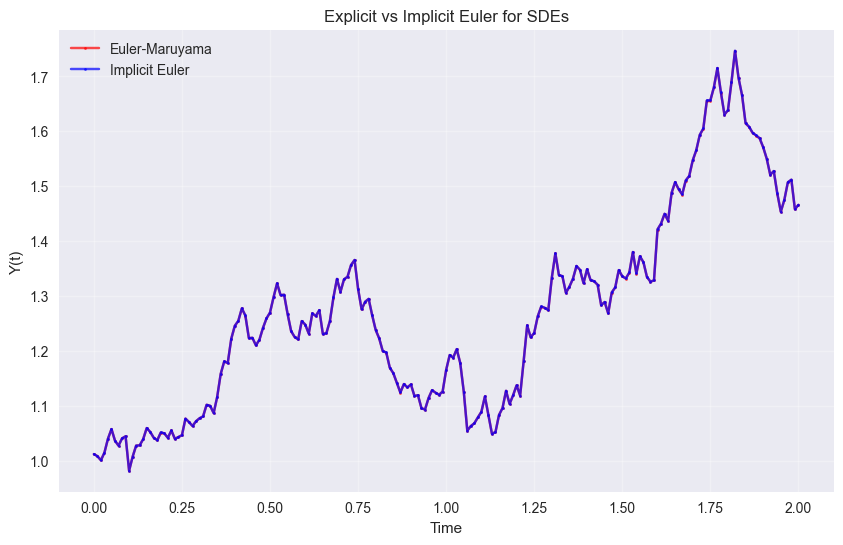

Final values:
Explicit Euler: 1.465971
Implicit Euler: 1.466222


In [9]:
# Test implicit Euler
brainstate.random.set_key(jax.random.PRNGKey(42))
y_implicit = integrate_sde(braintools.quad.sde_implicit_euler_step, gbm_drift, gbm_diffusion,
                           y0, t_array, mu, sigma, max_iter=3)

plt.figure(figsize=(10, 6))

plt.plot(t_array, y_euler_comp, 'ro-', markersize=2, label='Euler-Maruyama', alpha=0.7)
plt.plot(t_array, y_implicit, 'bo-', markersize=2, label='Implicit Euler', alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Y(t)')
plt.title('Explicit vs Implicit Euler for SDEs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final values:")
print(f"Explicit Euler: {y_euler_comp[-1]:.6f}")
print(f"Implicit Euler: {y_implicit[-1]:.6f}")

## 4. Stochastic Runge-Kutta Methods

Stochastic Runge-Kutta methods extend the deterministic RK schemes to SDEs (primarily for Stratonovich interpretation):

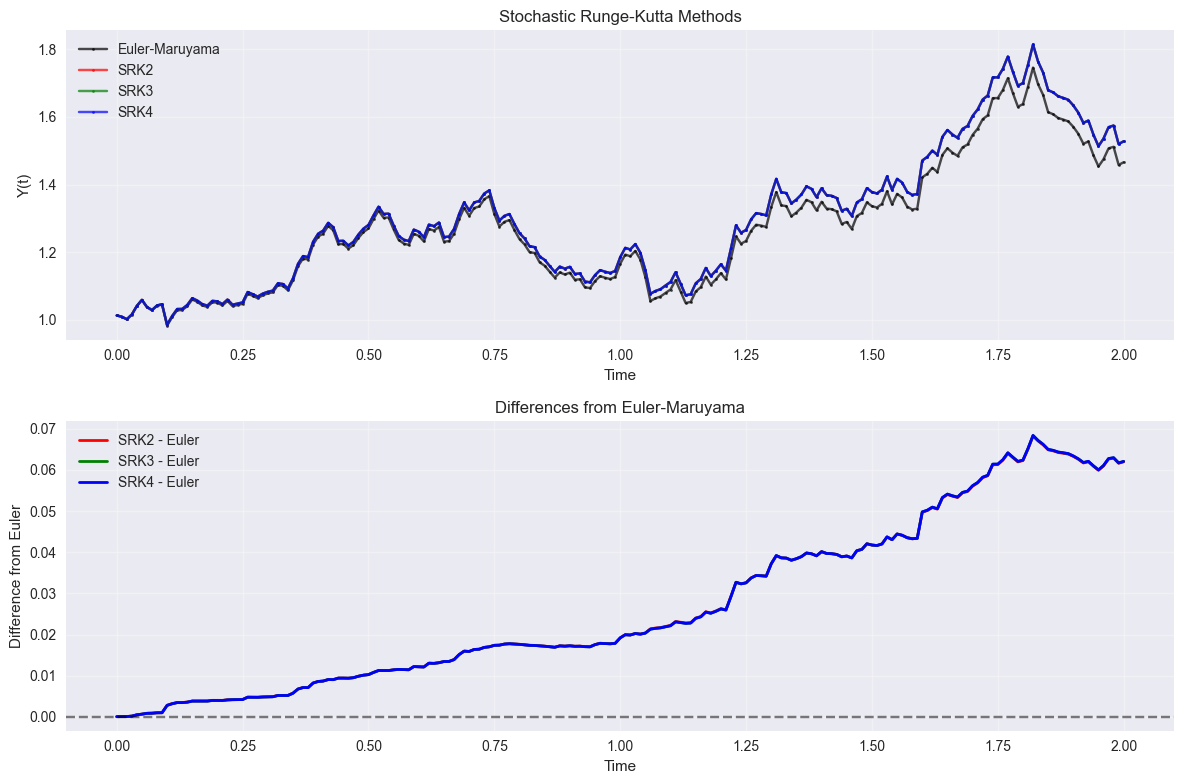

Final values:
Euler-Maruyama: 1.465971
SRK2:           1.527920
SRK3:           1.528004
SRK4:           1.528012


In [10]:
# Test Stochastic Runge-Kutta methods
brainstate.random.set_key(jax.random.PRNGKey(42))
y_srk2 = integrate_sde(braintools.quad.sde_srk2_step, gbm_drift, gbm_diffusion,
                       y0, t_array, mu, sigma)

brainstate.random.set_key(jax.random.PRNGKey(42))
y_srk3 = integrate_sde(braintools.quad.sde_srk3_step, gbm_drift, gbm_diffusion,
                       y0, t_array, mu, sigma)

brainstate.random.set_key(jax.random.PRNGKey(42))
y_srk4 = integrate_sde(braintools.quad.sde_srk4_step, gbm_drift, gbm_diffusion,
                       y0, t_array, mu, sigma)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t_array, y_euler_comp, 'ko-', markersize=2, label='Euler-Maruyama', alpha=0.7)
plt.plot(t_array, y_srk2, 'ro-', markersize=2, label='SRK2', alpha=0.7)
plt.plot(t_array, y_srk3, 'go-', markersize=2, label='SRK3', alpha=0.7)
plt.plot(t_array, y_srk4, 'bo-', markersize=2, label='SRK4', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Y(t)')
plt.title('Stochastic Runge-Kutta Methods')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot differences from Euler
plt.subplot(2, 1, 2)
plt.plot(t_array, y_srk2 - y_euler_comp, 'r-', linewidth=2, label='SRK2 - Euler')
plt.plot(t_array, y_srk3 - y_euler_comp, 'g-', linewidth=2, label='SRK3 - Euler')
plt.plot(t_array, y_srk4 - y_euler_comp, 'b-', linewidth=2, label='SRK4 - Euler')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Difference from Euler')
plt.title('Differences from Euler-Maruyama')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final values:")
print(f"Euler-Maruyama: {y_euler_comp[-1]:.6f}")
print(f"SRK2:           {y_srk2[-1]:.6f}")
print(f"SRK3:           {y_srk3[-1]:.6f}")
print(f"SRK4:           {y_srk4[-1]:.6f}")

## 5. Convergence Analysis

Let's analyze the strong and weak convergence properties of different SDE integrators.

**Strong convergence** measures $E[|Y_T^{\Delta t} - Y_T|]$ where $Y_T^{\Delta t}$ is the numerical solution.

**Weak convergence** measures $|E[f(Y_T^{\Delta t})] - E[f(Y_T)]|$ for smooth functions $f$.

Running strong convergence analysis...
Using 100 paths for each step size


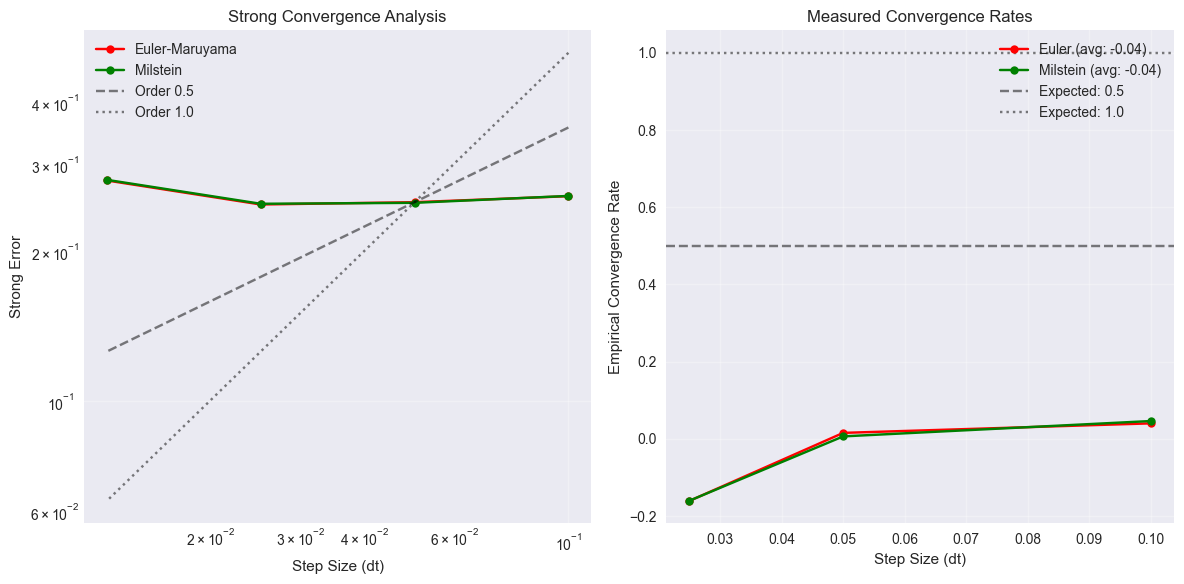


Empirical strong convergence rates:
Euler-Maruyama: -0.035 (expected: 0.5)
Milstein:       -0.036 (expected: 1.0)


In [11]:
# Strong convergence analysis
def strong_convergence_test(integrator_func, df, dg, y0, t_final, dt_values,
                            n_paths, analytical_func, **kwargs):
    """Test strong convergence by Monte Carlo"""
    errors = []

    for dt in dt_values:
        t_array_conv = jnp.arange(0, t_final + dt, dt)
        path_errors = []

        for i in range(n_paths):
            key = jax.random.PRNGKey(i + 1000)
            brainstate.random.set_key(key)

            # Numerical solution
            y_num = integrate_sde(integrator_func, df, dg, y0, t_array_conv, **kwargs)

            # Analytical solution (same random seed)
            brainstate.random.set_key(key)
            y_analytical = analytical_func(t_array_conv, y0, key)

            # Strong error at final time
            error = jnp.abs(y_num[-1] - y_analytical)
            path_errors.append(error)

        mean_error = jnp.mean(jnp.array(path_errors))
        errors.append(mean_error)

    return jnp.array(errors)


def analytical_gbm_final(t_array, y0, key):
    """Generate single analytical GBM path"""
    dt = t_array[1] - t_array[0]
    t_final = t_array[-1]
    dW = jax.random.normal(key, (len(t_array),)) * jnp.sqrt(dt)
    W_final = jnp.sum(dW[:-1])  # Exclude last point
    return y0 * jnp.exp((mu - 0.5 * sigma ** 2) * t_final + sigma * W_final)


# Convergence test parameters
dt_values_conv = jnp.array([0.1, 0.05, 0.025, 0.0125])
t_final_conv = 1.0
n_paths_conv = 100

print("Running strong convergence analysis...")
print(f"Using {n_paths_conv} paths for each step size")

# Test Euler-Maruyama
errors_euler = strong_convergence_test(
    braintools.quad.sde_euler_step, gbm_drift, gbm_diffusion, y0,
    t_final_conv, dt_values_conv, n_paths_conv,
    analytical_gbm_final, mu=mu, sigma=sigma
)

# Test Milstein
errors_milstein = strong_convergence_test(
    braintools.quad.sde_milstein_step, gbm_drift, gbm_diffusion, y0,
    t_final_conv, dt_values_conv, n_paths_conv,
    analytical_gbm_final, mu=mu, sigma=sigma, sde_type='ito'
)

# Plot strong convergence
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.loglog(dt_values_conv, errors_euler, 'ro-', markersize=6, label='Euler-Maruyama')
plt.loglog(dt_values_conv, errors_milstein, 'go-', markersize=6, label='Milstein')

# Theoretical slopes
dt_ref = dt_values_conv[1]
error_ref = errors_euler[1]
plt.loglog(dt_values_conv, error_ref * (dt_values_conv / dt_ref) ** 0.5, 'k--',
           alpha=0.5, label='Order 0.5')
plt.loglog(dt_values_conv, error_ref * (dt_values_conv / dt_ref) ** 1.0, 'k:',
           alpha=0.5, label='Order 1.0')

plt.xlabel('Step Size (dt)')
plt.ylabel('Strong Error')
plt.title('Strong Convergence Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

# Calculate empirical convergence rates
plt.subplot(1, 2, 2)
rates_euler = []
rates_milstein = []

for i in range(len(dt_values_conv) - 1):
    rate_euler = jnp.log(errors_euler[i] / errors_euler[i + 1]) / jnp.log(dt_values_conv[i] / dt_values_conv[i + 1])
    rate_milstein = jnp.log(errors_milstein[i] / errors_milstein[i + 1]) / jnp.log(
        dt_values_conv[i] / dt_values_conv[i + 1])
    rates_euler.append(rate_euler)
    rates_milstein.append(rate_milstein)

plt.plot(dt_values_conv[:-1], rates_euler, 'ro-', markersize=6,
         label=f'Euler (avg: {np.mean(rates_euler):.2f})')
plt.plot(dt_values_conv[:-1], rates_milstein, 'go-', markersize=6,
         label=f'Milstein (avg: {np.mean(rates_milstein):.2f})')

plt.axhline(y=0.5, color='k', linestyle='--', alpha=0.5, label='Expected: 0.5')
plt.axhline(y=1.0, color='k', linestyle=':', alpha=0.5, label='Expected: 1.0')

plt.xlabel('Step Size (dt)')
plt.ylabel('Empirical Convergence Rate')
plt.title('Measured Convergence Rates')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nEmpirical strong convergence rates:")
print(f"Euler-Maruyama: {np.mean(rates_euler):.3f} (expected: 0.5)")
print(f"Milstein:       {np.mean(rates_milstein):.3f} (expected: 1.0)")

## 6. Neuroscience Example: Stochastic FitzHugh-Nagumo Model

Let's apply SDE integrators to a neuroscience model with noise - the stochastic FitzHugh-Nagumo model:

$$dV = (V - \frac{V^3}{3} - W + I) dt + \sigma_V dW_1$$
$$dW = \epsilon (V + a - bW) dt + \sigma_W dW_2$$

This models a neuron with voltage-dependent and recovery-variable dynamics plus noise.

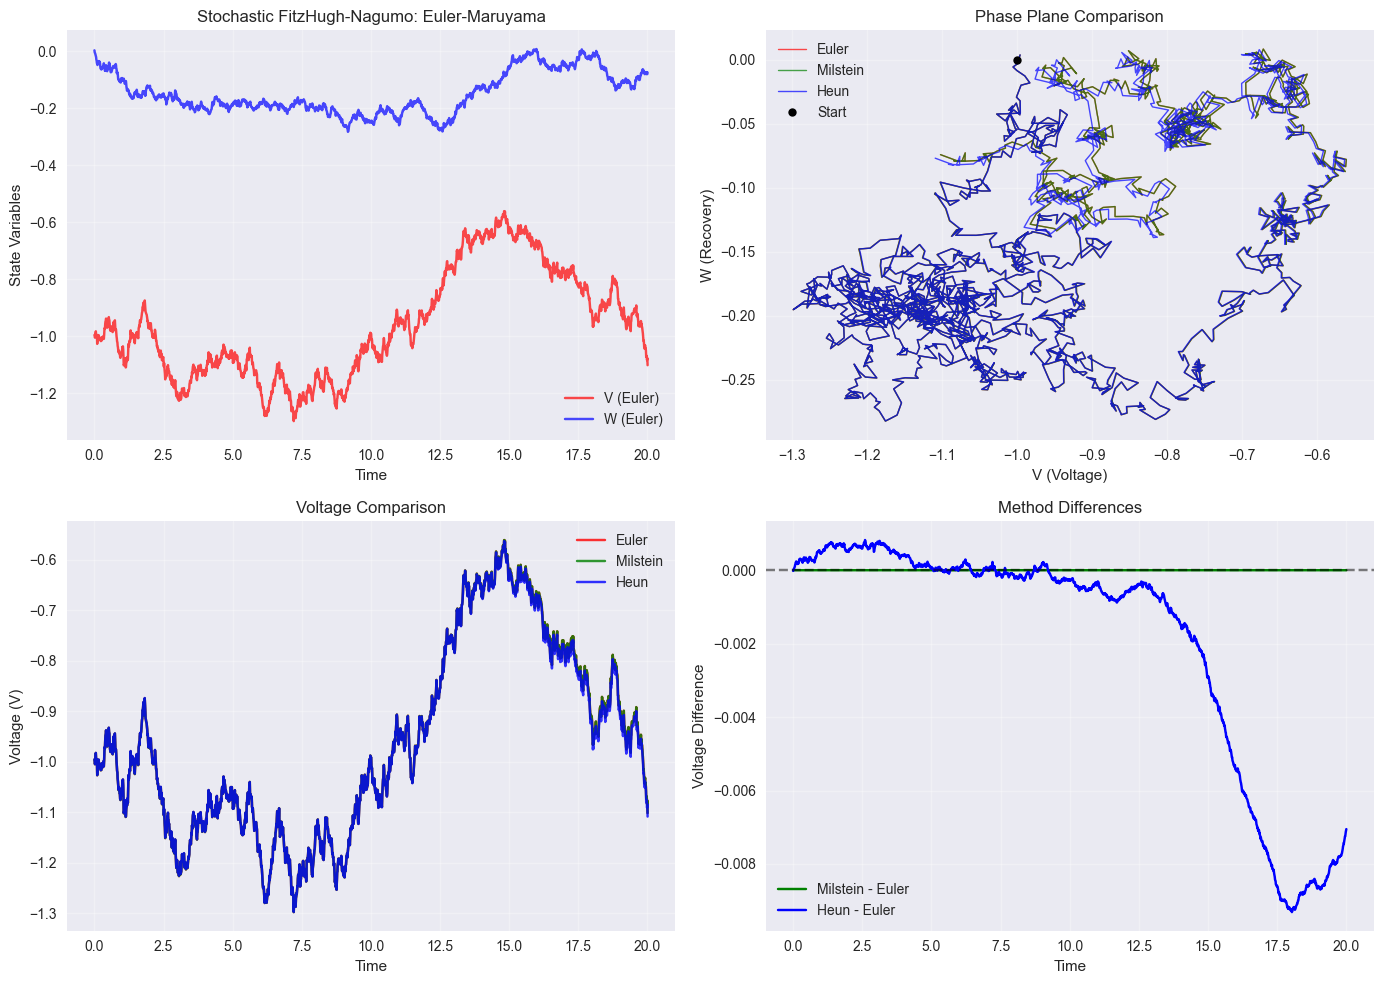

FitzHugh-Nagumo simulation completed
Final states:
Euler:    V=-1.1017, W=-0.0742
Milstein: V=-1.1017, W=-0.0742
Heun:     V=-1.1087, W=-0.0769

Voltage statistics (Euler):
Mean: -0.9633, Std: 0.1878
Min: -1.2980, Max: -0.5608


In [12]:
# Stochastic FitzHugh-Nagumo model
def fhn_drift(state, t, I_ext=0.0, a=0.7, b=0.8, epsilon=0.08, **kwargs):
    """FitzHugh-Nagumo drift function"""
    V, W = state
    dV = V - V ** 3 / 3 - W + I_ext
    dW = epsilon * (V + a - b * W)
    return jnp.array([dV, dW])


def fhn_diffusion(state, t, sigma_V=0.1, sigma_W=0.05, **kwargs):
    """FitzHugh-Nagumo diffusion function"""
    V, W = state
    return jnp.array([sigma_V, sigma_W])


# Parameters
state0 = jnp.array([-1.0, 0.0])  # Initial state [V, W]
I_ext = 0.5
a, b, epsilon = 0.7, 0.8, 0.08
sigma_V, sigma_W = 0.1, 0.05
t_final_fhn = 20.0
dt_fhn = 0.01
t_array_fhn = jnp.arange(0, t_final_fhn + dt_fhn, dt_fhn)

# Integrate with different methods
brainstate.random.set_key(jax.random.PRNGKey(42))
states_euler = integrate_sde(
    braintools.quad.sde_euler_step, fhn_drift, fhn_diffusion,
    state0, t_array_fhn, I_ext=I_ext, a=a, b=b, epsilon=epsilon, sigma_V=sigma_V, sigma_W=sigma_W
)

brainstate.random.set_key(jax.random.PRNGKey(42))
states_milstein = integrate_sde(
    braintools.quad.sde_milstein_step, fhn_drift, fhn_diffusion,
    state0, t_array_fhn, I_ext=I_ext, a=a, b=b, epsilon=epsilon, sigma_V=sigma_V, sigma_W=sigma_W,
    sde_type='ito'
)

brainstate.random.set_key(jax.random.PRNGKey(42))
states_heun = integrate_sde(
    braintools.quad.sde_heun_step, fhn_drift, fhn_diffusion,
    state0, t_array_fhn, I_ext=I_ext, a=a, b=b, epsilon=epsilon, sigma_V=sigma_V, sigma_W=sigma_W,
    sde_type='ito'
)

# Extract V and W from states
V_euler, W_euler = states_euler[:, 0], states_euler[:, 1]
V_milstein, W_milstein = states_milstein[:, 0], states_milstein[:, 1]
V_heun, W_heun = states_heun[:, 0], states_heun[:, 1]

# Plot results
plt.figure(figsize=(14, 10))

# Time series
plt.subplot(2, 2, 1)
plt.plot(t_array_fhn, V_euler, 'r-', alpha=0.7, label='V (Euler)')
plt.plot(t_array_fhn, W_euler, 'b-', alpha=0.7, label='W (Euler)')
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.title('Stochastic FitzHugh-Nagumo: Euler-Maruyama')
plt.legend()
plt.grid(True, alpha=0.3)

# Phase plane
plt.subplot(2, 2, 2)
plt.plot(V_euler, W_euler, 'r-', alpha=0.7, linewidth=1, label='Euler')
plt.plot(V_milstein, W_milstein, 'g-', alpha=0.7, linewidth=1, label='Milstein')
plt.plot(V_heun, W_heun, 'b-', alpha=0.7, linewidth=1, label='Heun')
plt.plot(state0[0], state0[1], 'ko', markersize=6, label='Start')
plt.xlabel('V (Voltage)')
plt.ylabel('W (Recovery)')
plt.title('Phase Plane Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Method comparison - voltage
plt.subplot(2, 2, 3)
plt.plot(t_array_fhn, V_euler, 'r-', alpha=0.8, label='Euler')
plt.plot(t_array_fhn, V_milstein, 'g-', alpha=0.8, label='Milstein')
plt.plot(t_array_fhn, V_heun, 'b-', alpha=0.8, label='Heun')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.title('Voltage Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Differences
plt.subplot(2, 2, 4)
plt.plot(t_array_fhn, V_milstein - V_euler, 'g-', label='Milstein - Euler')
plt.plot(t_array_fhn, V_heun - V_euler, 'b-', label='Heun - Euler')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Voltage Difference')
plt.title('Method Differences')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"FitzHugh-Nagumo simulation completed")
print(f"Final states:")
print(f"Euler:    V={V_euler[-1]:.4f}, W={W_euler[-1]:.4f}")
print(f"Milstein: V={V_milstein[-1]:.4f}, W={W_milstein[-1]:.4f}")
print(f"Heun:     V={V_heun[-1]:.4f}, W={W_heun[-1]:.4f}")

# Statistics
print(f"\nVoltage statistics (Euler):")
print(f"Mean: {jnp.mean(V_euler):.4f}, Std: {jnp.std(V_euler):.4f}")
print(f"Min: {jnp.min(V_euler):.4f}, Max: {jnp.max(V_euler):.4f}")

### Multiple Noise Realizations

Let's generate multiple realizations to see the stochastic behavior:

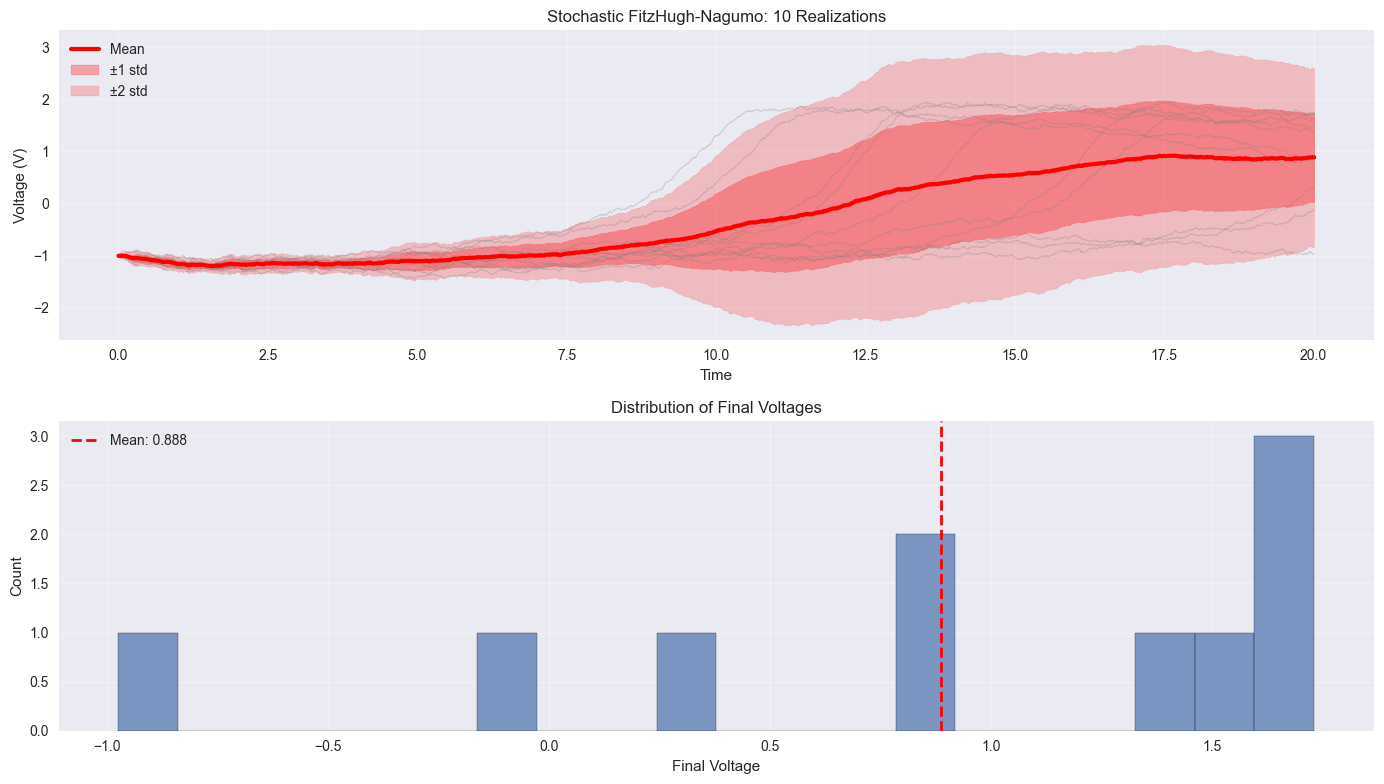

Statistics from 10 realizations:
Final voltage - Mean: 0.8878, Std: 0.8540
Final voltage - Min: -0.9736, Max: 1.7321


In [13]:
# Generate multiple realizations
n_realizations = 10
V_realizations = []

for i in range(n_realizations):
    brainstate.random.set_key(jax.random.PRNGKey(i + 100))
    states = integrate_sde(
        braintools.quad.sde_milstein_step, fhn_drift, fhn_diffusion,
        state0, t_array_fhn, I_ext=I_ext, a=a, b=b, epsilon=epsilon, sigma_V=sigma_V, sigma_W=sigma_W,
        sde_type='ito'
    )
    V_realizations.append(states[:, 0])

V_realizations = jnp.array(V_realizations)

# Calculate statistics
V_mean = jnp.mean(V_realizations, axis=0)
V_std = jnp.std(V_realizations, axis=0)

plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
# Plot all realizations in light gray
for i in range(n_realizations):
    plt.plot(t_array_fhn, V_realizations[i], 'gray', alpha=0.3, linewidth=0.8)

# Plot mean and confidence bands
plt.plot(t_array_fhn, V_mean, 'r-', linewidth=3, label='Mean')
plt.fill_between(t_array_fhn, V_mean - V_std, V_mean + V_std,
                 alpha=0.3, color='red', label='±1 std')
plt.fill_between(t_array_fhn, V_mean - 2 * V_std, V_mean + 2 * V_std,
                 alpha=0.2, color='red', label='±2 std')

plt.xlabel('Time')
plt.ylabel('Voltage (V)')
plt.title(f'Stochastic FitzHugh-Nagumo: {n_realizations} Realizations')
plt.legend()
plt.grid(True, alpha=0.3)

# Phase plane for multiple realizations
plt.subplot(2, 1, 2)
for i in range(n_realizations):
    W_i = V_realizations[i]  # Extract W from states if needed
    # For simplicity, just show voltage histogram

# Histogram at final time
final_voltages = V_realizations[:, -1]
plt.hist(final_voltages, bins=20, alpha=0.7, edgecolor='black')
plt.axvline(jnp.mean(final_voltages), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {jnp.mean(final_voltages):.3f}')
plt.xlabel('Final Voltage')
plt.ylabel('Count')
plt.title('Distribution of Final Voltages')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Statistics from {n_realizations} realizations:")
print(f"Final voltage - Mean: {jnp.mean(final_voltages):.4f}, Std: {jnp.std(final_voltages):.4f}")
print(f"Final voltage - Min: {jnp.min(final_voltages):.4f}, Max: {jnp.max(final_voltages):.4f}")

## 7. Performance Comparison

Let's compare the computational efficiency of different SDE integrators:

Timing SDE integrators over 1000 steps...
Euler     : 0.1320 seconds, final value: 0.651900
Milstein  : 0.1155 seconds, final value: 0.662962
Heun      : 0.1132 seconds, final value: 0.651795
SRK2      : 0.1059 seconds, final value: 0.809137

Relative timing (vs Euler-Maruyama):
Euler     : 1.00x
Milstein  : 0.87x
Heun      : 0.86x
SRK2      : 0.80x


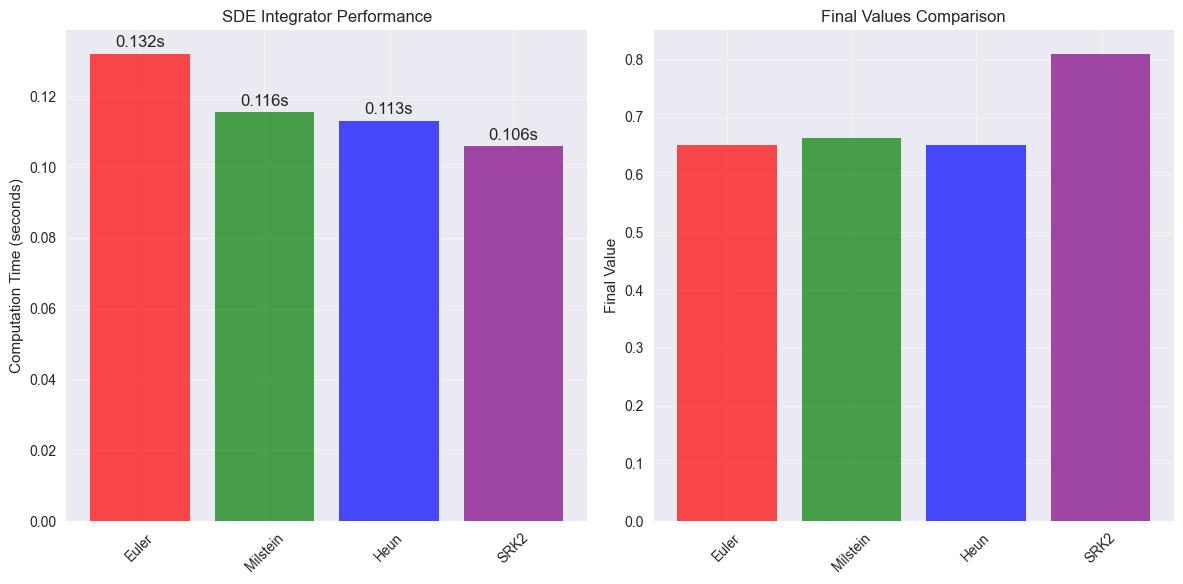

In [14]:
import time


# Timing test setup for SDEs
def time_sde_integrator(integrator_func, df, dg, y0, n_steps, dt_val, *args, **kwargs):
    """Time an SDE integrator over n_steps"""
    t_array_timing = jnp.arange(0, n_steps * dt_val, dt_val)

    # Warm-up run (for JAX compilation)
    _ = integrate_sde(integrator_func, df, dg, y0, t_array_timing[:10], *args, **kwargs)

    # Actual timing
    start_time = time.time()
    result = integrate_sde(integrator_func, df, dg, y0, t_array_timing, *args, **kwargs)
    end_time = time.time()

    return end_time - start_time, result[-1]


# Timing parameters
n_steps_timing = 1000
dt_timing = 0.01

timing_methods = {
    'Euler': (braintools.quad.sde_euler_step, {}),
    'Milstein': (braintools.quad.sde_milstein_step, {'sde_type': 'ito'}),
    'Heun': (braintools.quad.sde_heun_step, {'sde_type': 'ito'}),
    'SRK2': (braintools.quad.sde_srk2_step, {}),
}

times = {}
final_values = {}

print(f"Timing SDE integrators over {n_steps_timing} steps...")
for name, (method, kwargs) in timing_methods.items():
    brainstate.random.set_key(jax.random.PRNGKey(42))  # Same seed for all
    elapsed, final_val = time_sde_integrator(
        method, gbm_drift, gbm_diffusion, y0, n_steps_timing, dt_timing,
        mu, sigma, **kwargs
    )
    times[name] = elapsed
    final_values[name] = final_val
    print(f"{name:10s}: {elapsed:.4f} seconds, final value: {final_val:.6f}")

# Efficiency analysis
euler_time = times['Euler']
print("\nRelative timing (vs Euler-Maruyama):")
for name, time_val in times.items():
    print(f"{name:10s}: {time_val / euler_time:.2f}x")

# Create performance visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
methods_list = list(times.keys())
times_list = [times[name] for name in methods_list]
bars = plt.bar(methods_list, times_list, alpha=0.7,
               color=['red', 'green', 'blue', 'purple'])
plt.ylabel('Computation Time (seconds)')
plt.title('SDE Integrator Performance')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, time_val in zip(bars, times_list):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001,
             f'{time_val:.3f}s', ha='center', va='bottom')

plt.subplot(1, 2, 2)
final_vals = [final_values[name] for name in methods_list]
plt.bar(methods_list, final_vals, alpha=0.7,
        color=['red', 'green', 'blue', 'purple'])
plt.ylabel('Final Value')
plt.title('Final Values Comparison')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

This tutorial covered the key SDE integrators available in BrainTools:

### **Basic Methods:**
- **Euler-Maruyama**: Simple, strong order 0.5, weak order 1.0
- **Milstein**: Higher accuracy with strong order 1.0
- **Exponential Euler**: Better stability for stiff SDEs

### **Advanced Methods:**
- **Stochastic Heun**: Predictor-corrector scheme
- **Tamed Euler**: Prevents explosion for superlinear growth
- **Implicit Euler**: Enhanced stability via fixed-point iteration
- **SRK methods**: Stochastic Runge-Kutta for Stratonovich SDEs

### **Key Concepts:**
- **Itô vs Stratonovich**: Different stochastic calculus interpretations
- **Strong vs Weak convergence**: Different measures of accuracy
- **Noise handling**: All methods use `brainstate.random` for Gaussian noise

### **Guidelines:**
1. **For most problems**: Use Euler-Maruyama or Milstein
2. **For higher accuracy**: Use Milstein (strong order 1.0)
3. **For stiff problems**: Try Exponential Euler or Tamed Euler
4. **For superlinear growth**: Use Tamed Euler
5. **For Stratonovich SDEs**: Consider SRK methods

### **BrainTools Features:**
- All methods work with JAX PyTrees
- Global time step management via `brainstate.environ`
- Consistent random number handling via `brainstate.random`
- Support for both Itô and Stratonovich interpretations
- Unit-aware computations with `brainunit`

Choose your SDE integrator based on the trade-off between accuracy, stability, and computational cost for your specific stochastic system.